In the previous notebook we've identified, analyzed and solved the inconsistences in our dataset. In some cases, for machine learning models, it is necessary to create new features to model the problem. This notebook aims to do the necessary feature engineering.

# Imports

In [38]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import mlflow
import mlflow.sklearn
%matplotlib inline
sns.set_style("white")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn import metrics
from scipy import stats
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor

from IPython.display import Image

# Set-up

In [3]:
os.chdir('../..')

In [5]:
warnings.filterwarnings("ignore")

# Get Data

In [6]:
df = pd.read_parquet('./data/1-bronze/Concrete_Data_Cleaned.parquet')

# Feature Engineering

In [7]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,272.9,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,272.9,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,185.0,0.0,932.0,594.0,28,40.27
3,332.5,142.5,0.0,185.0,0.0,932.0,594.0,28,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,28,44.30


The strength is the target variable, let's divide the dataset in dependent and independent variables and scale the data avoid data leakage.

In [8]:
df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

In [9]:
# spitting data into dependent and independent variables

X = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age']]
y = df[['strength']]

In order to scale our data, let us use the z score.

In [10]:
Xscaled = X.apply(zscore)
X_scaled_df = pd.DataFrame(Xscaled, columns = df.columns)

In [11]:
X_scaled_df = X_scaled_df.drop(columns = 'strength')

In [12]:
X_scaled_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,0.147951,-0.830600,-0.822730,-1.004275,-0.618977,1.262346,-1.282281,0.300203
1,0.147951,-0.830600,-0.822730,-1.004275,-0.618977,1.496911,-1.282281,0.300203
2,0.892690,1.130849,-0.822730,0.396167,-1.156464,-0.426523,-2.543096,0.300203
3,0.892690,1.130849,-0.822730,0.396167,-1.156464,-0.426523,-2.543096,0.300203
4,-0.780475,0.991827,-0.822730,0.822389,-1.156464,0.299065,1.016402,0.300203
...,...,...,...,...,...,...,...,...
1025,0.191685,0.766088,0.642499,0.067368,0.756991,-1.394495,0.136906,0.300203
1026,0.763985,-0.830600,1.053023,1.065944,1.079483,-2.210781,0.830354,0.300203
1027,-1.406506,1.088179,0.939440,0.865011,0.155005,-1.045775,0.316803,0.300203
1028,-1.274052,1.739242,-0.822730,-0.176187,1.272979,0.474207,0.453647,0.300203


# Building Different Models

In [13]:
# splitting in train and test data
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size = 0.3, random_state = 1)

# MLFlow Experiment - Functions

In [14]:
def train(model, X_train: pd.DataFrame, y_train: pd.DataFrame) -> None:
  '''
  Fits a scikit-learn model
  '''
  try:
    model = model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    mlflow.log_metric('train-accuracy', train_accuracy)
    print(f'Train Accuracy: {train_accuracy: .3%}')
  except Exception as e:
    raise(e)

  return None

In [15]:
def evaluate(model, X_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
    # Model predictions
    y_pred = model.predict(X_test)

    # Model performance metrics
    r2_score = metrics.r2_score(y_test, y_pred)
    mse_score = metrics.mean_squared_error(y_test, y_pred)

    # Log metrics
    mlflow.log_metric('r2-score', r2_score)
    mlflow.log_metric('mse', mse_score)

    # Print and log metrics
    print('R2 Score: {:.3f}'.format(r2_score))
    print('-' * 30)
    print('MSE: {:.3f}'.format(mse_score))

    print('-' * 30)
    print('Metrics and artifacts logged!')

    return None


# Random Forest

In [17]:
random_forest = RandomForestRegressor()

In [18]:
mlflow.set_experiment('Concrete-Strength-Experiments')

# Start a new MLflow run
with mlflow.start_run():
    # Set a custom run name
    run_name = "Random Forest"
    mlflow.set_tag("mlflow.runName", run_name)

    # Train the model
    train(model=random_forest, X_train=X_train, y_train=y_train)

    # Log hyperparameters
    mlflow.log_param('n_estimators', random_forest.n_estimators)
    mlflow.log_param('max_depth', random_forest.max_depth)

    # Evaluate on the test set
    evaluate(model=random_forest, X_test=X_test, y_test=y_test)

    # Perform cross-validation
    k = 20
    kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
    K_results = cross_val_score(random_forest, X, y, cv = kfold)
    accuracy = np.mean(abs(K_results))

    # Log cross-validation metric
    mlflow.log_metric('cv_accuracy', accuracy)
    print('cv accuracy: ', accuracy)

    # Log the model
    mlflow.sklearn.log_model(random_forest, 'random-forest')

    # Print the run UUID
    print('Model run: ', mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()


2023/07/16 18:02:12 INFO mlflow.tracking.fluent: Experiment with name 'Concrete-Strength-Experiments' does not exist. Creating a new experiment.


Train Accuracy:  96.509%
R2 Score: 0.847
------------------------------
MSE: 40.217
------------------------------
Metrics and artifacts logged!
cv accuracy:  0.865300222145633
Model run:  8977191a0af847ce892e666056fdfe66


The model has overfitted because the train and test scores are supposed to be closer.

# Gradient Boosting Regressor

In [22]:
# gradient boosting model
gradient_boosting = GradientBoostingRegressor()

In [23]:
# Start a new MLflow run
with mlflow.start_run():
    # Set a custom run name
    run_name = "Gradient Boosting"
    mlflow.set_tag("mlflow.runName", run_name)

    # Train the model
    train(model=gradient_boosting, X_train=X_train, y_train=y_train)

    # Log hyperparameters
    mlflow.log_param('n_estimators', gradient_boosting.n_estimators)

    # Evaluate on the test set
    evaluate(model=gradient_boosting, X_test = X_test, y_test=y_test)

    # Perform cross-validation
    k = 20
    kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
    K_results = cross_val_score(gradient_boosting, X, y, cv = kfold)
    accuracy = np.mean(abs(K_results))

    # Log cross-validation metric
    mlflow.log_metric('cv_accuracy', accuracy)
    print('cv accuracy: ', accuracy)

    # Log the model
    mlflow.sklearn.log_model(gradient_boosting, 'gradient-boosting')

    # Print the run UUID
    print('Model run: ', mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()

Train Accuracy:  91.291%
R2 Score: 0.830
------------------------------
MSE: 44.584
------------------------------
Metrics and artifacts logged!
cv accuracy:  0.8554210267441394
Model run:  9b1561393cb74b33b5b8e7ba5194e815


# Ada Boosting Regressor

In [24]:
# ada boosting model
ada_boost = AdaBoostRegressor()

In [25]:
# Start a new MLflow run
with mlflow.start_run():
    # Set a custom run name
    run_name = "Ada Boost"
    mlflow.set_tag("mlflow.runName", run_name)

    # Train the model
    train(model=ada_boost, X_train=X_train, y_train=y_train)

    # Log hyperparameters
    mlflow.log_param('n_estimators', ada_boost.n_estimators)

    # Evaluate on the test set
    evaluate(model=ada_boost, X_test = X_test, y_test=y_test)

    # Perform cross-validation
    k = 20
    kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
    K_results = cross_val_score(ada_boost, X, y, cv = kfold)
    accuracy = np.mean(abs(K_results))

    # Log cross-validation metric
    mlflow.log_metric('cv_accuracy', accuracy)

    print('cv accuracy: ', accuracy)

    # Log the model
    mlflow.sklearn.log_model(ada_boost, 'ada-boost')

    # Print the run UUID
    print('Model run: ', mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()

Train Accuracy:  76.634%
R2 Score: 0.711
------------------------------
MSE: 75.675
------------------------------
Metrics and artifacts logged!
cv accuracy:  0.7301976290471304
Model run:  5fcdcf5c1f2a4c5e9ba717b187a02734


# KNN Regressor

In [26]:
# checking for different values of neighbors to determine the best number

diff_k = []
for i in range(1, 45):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    diff_k.append(np.mean(pred_i != y_test))

Let us visualize the mean error for each value

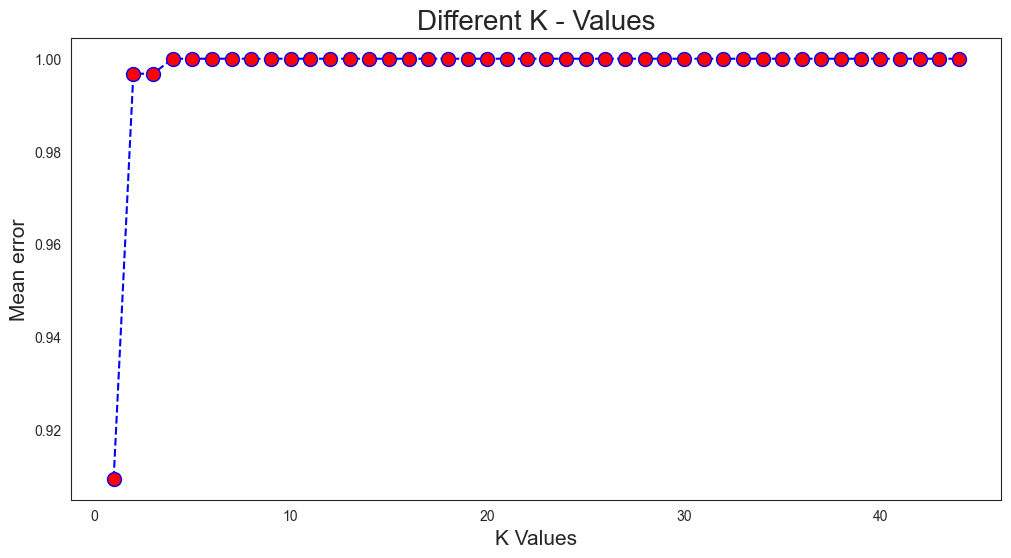

In [27]:
plt.figure(figsize = (12, 6))
plt.plot(range(1, 45), diff_k, color = 'blue', linestyle = 'dashed', marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('Different K - Values', fontsize = 20)
plt.xlabel('K Values', fontsize = 15)
plt.ylabel('Mean error', fontsize = 15);

In [28]:
# k = 3 is a better choice
KNN = KNeighborsRegressor(n_neighbors = 3)

In [29]:
# Start a new MLflow run
with mlflow.start_run():
    # Set a custom run name
    run_name = "KNN Regressor"
    mlflow.set_tag("mlflow.runName", run_name)

    # Train the model
    train(model=KNN, X_train=X_train, y_train=y_train)

    # Log hyperparameters
    mlflow.log_param('n_neighbors', KNN.n_neighbors)

    # Evaluate on the test set
    evaluate(model=KNN, X_test = X_test, y_test=y_test)

    # Perform cross-validation
    k = 20
    kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
    K_results = cross_val_score(KNN, X, y, cv = kfold)
    accuracy = np.mean(abs(K_results))

    # Log cross-validation metric
    mlflow.log_metric('cv_accuracy', accuracy)

    print('cv accuracy: ', accuracy)

    # Log the model
    mlflow.sklearn.log_model(KNN, 'KNN')

    # Print the run UUID
    print('Model run: ', mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()

Train Accuracy:  89.268%
R2 Score: 0.733
------------------------------
MSE: 70.035
------------------------------
Metrics and artifacts logged!
cv accuracy:  0.5648537541937363
Model run:  355930aab0bb4150b78f6287ea78ab42


# Bagging Regressor

In [30]:
# bagging regressor model
bagging = BaggingRegressor()

In [31]:
# Start a new MLflow run
with mlflow.start_run():
    # Set a custom run name
    run_name = "Bagging"
    mlflow.set_tag("mlflow.runName", run_name)

    # Train the model
    train(model=bagging, X_train=X_train, y_train=y_train)

    # Log hyperparameters
    mlflow.log_param('n_estimators', bagging.n_estimators)

    # Evaluate on the test set
    evaluate(model=bagging, X_test = X_test, y_test=y_test)

    # Perform cross-validation
    k = 20
    kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
    K_results = cross_val_score(ada_boost, X, y, cv = kfold)
    accuracy = np.mean(abs(K_results))

    # Log cross-validation metric
    mlflow.log_metric('cv_accuracy', accuracy)
    print('cv accuracy: {:.3f}'.format(accuracy))

    # Log the model
    mlflow.sklearn.log_model(bagging, 'bagging')

    # Print the run UUID
    print('Model run: ', mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()

Train Accuracy:  95.763%
R2 Score: 0.812
------------------------------
MSE: 49.370
------------------------------
Metrics and artifacts logged!
cv accuracy: 0.717
Model run:  9932d0ac56c242b58b2de46960bab005


# Support Vector Regressor

In [32]:
# support vector model
SVR = SVR(kernel = 'linear')

In [33]:
# Start a new MLflow run
with mlflow.start_run():
    # Set a custom run name
    run_name = "svr"
    mlflow.set_tag("mlflow.runName", run_name)

    # Train the model
    train(model=SVR, X_train=X_train, y_train=y_train)

    # Log hyperparameters
    params = {
        'kernel': SVR.kernel,
    }
    for key, value in params.items():
      mlflow.log_param(key, value)

    # Evaluate on the test set
    evaluate(model=SVR, X_test = X_test, y_test=y_test)

    # Perform cross-validation
    k = 20
    kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
    K_results = cross_val_score(ada_boost, X, y, cv = kfold)
    accuracy = np.mean(abs(K_results))

    # Log cross-validation metric
    mlflow.log_metric('cv_accuracy', accuracy)
    print('cv accuracy: {:.3f}'.format(accuracy))

    # Log the model
    mlflow.sklearn.log_model(SVR, 'svr')

    # Print the run UUID
    print('Model run: ', mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()

Train Accuracy:  66.721%
R2 Score: 0.569
------------------------------
MSE: 112.921
------------------------------
Metrics and artifacts logged!
cv accuracy: 0.728
Model run:  663fc1927b364acda888e43c638153f1


# XGBoost Regressor

In [34]:
# xgboost regressor model
xgr = XGBRegressor()

In [35]:
# Start a new MLflow run
with mlflow.start_run():
    # Set a custom run name
    run_name = "XGBoost"
    mlflow.set_tag("mlflow.runName", run_name)

    # Train the model
    train(model=xgr, X_train=X_train, y_train=y_train)


    # Evaluate on the test set
    evaluate(model=xgr, X_test = X_test, y_test=y_test)

    # Perform cross-validation
    k = 20
    kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
    K_results = cross_val_score(xgr, X, y, cv = kfold)
    accuracy = np.mean(abs(K_results))

    # Log cross-validation metric
    mlflow.log_metric('cv_accuracy', accuracy)
    print('cv accuracy: {:.3f}'.format(accuracy))

    # Log the model
    mlflow.sklearn.log_model(xgr, 'xgboost')

    # Print the run UUID
    print('Model run: ', mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()

Train Accuracy:  97.753%
R2 Score: 0.832
------------------------------
MSE: 44.158
------------------------------
Metrics and artifacts logged!
cv accuracy: 0.869
Model run:  2f650498d25a482cb9f66c9f9bee6b96


# Decision Tree Regressor

In [36]:
# xgboost regressor model
dt_model = DecisionTreeRegressor()

In [37]:
# Start a new MLflow run
with mlflow.start_run():
    # Set a custom run name
    run_name = "Decision Tree"
    mlflow.set_tag("mlflow.runName", run_name)

    # Train the model
    train(model=dt_model, X_train=X_train, y_train=y_train)

    # Log hyperparameters
    mlflow.log_param("max_depth", dt_model.max_depth)
    mlflow.log_param("min_samples_split", dt_model.min_samples_split)
    mlflow.log_param("min_samples_leaf", dt_model.min_samples_leaf)
    mlflow.log_param("max_features", dt_model.max_features)

    # Evaluate on the test set
    evaluate(model=dt_model, X_test=X_test, y_test=y_test)

    # Perform cross-validation
    k = 20
    kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
    K_results = cross_val_score(dt_model, X, y, cv = kfold)
    accuracy = np.mean(abs(K_results))

    # Log cross-validation metric
    mlflow.log_metric('cv_accuracy', accuracy)
    print('cv accuracy: ', accuracy)

    # Log the model
    mlflow.sklearn.log_model(dt_model, 'decision-tree')

    # Print the run UUID
    print('Model run: ', mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()

Train Accuracy:  97.812%
R2 Score: 0.765
------------------------------
MSE: 61.654
------------------------------
Metrics and artifacts logged!
cv accuracy:  0.7909050881453388
Model run:  17ab311e3f534c12a688242d96080e03


# Model Evaluation Metrics

Now let us evaluate the metrics of our tested models using **mlflow**:

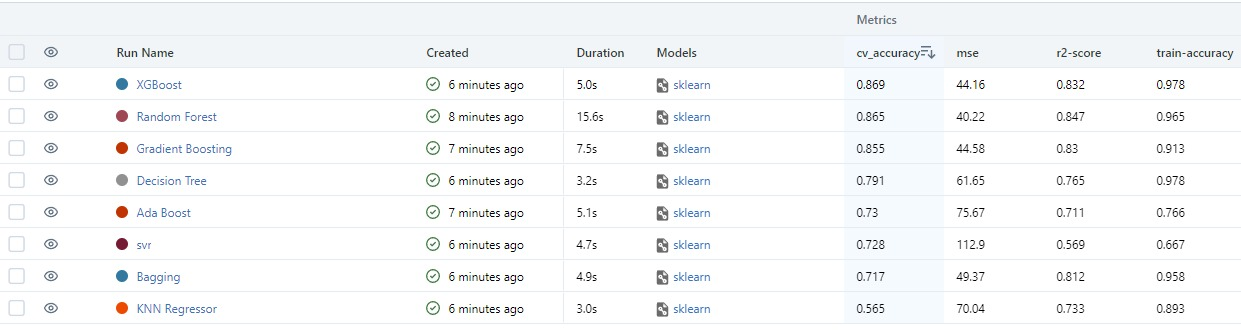

In [39]:
Image(filename = './images/MLFlow-image-1.jpeg')

As we can see, our best model was XGBoost. Let's now register and save our model using MLFlow:

In [40]:
xgboost_run_id = '2f650498d25a482cb9f66c9f9bee6b96'

model_uri = f'runs:/{xgboost_run_id}/model'
model_details = mlflow.register_model(model_uri, 'XGBoost Model')

Successfully registered model 'XGBoost Model'.
2023/07/16 18:22:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost Model, version 1
Created version '1' of model 'XGBoost Model'.


In [45]:
mlflow.sklearn.save_model(model_details, 'model')

2023/07/16 18:35:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
